# Inside Airbnb: Berlin

Airbnb has been in many places in the world subject to criticism for misuse of apartments and increase in home rents. To provide adequate data as a basis for discussions and decisionmakers in the affected cities, [insideairbnb.com](insideairbnb.com) provides real-world data about accomodations that are offered by hosts and also about reviews which have been submitted by guests.

For this project I will use the following files provided by the project:
  - [listings](http://data.insideairbnb.com/germany/be/berlin/2022-09-15/visualisations/listings.csv): The offered accomodations
  - [reviews](http://data.insideairbnb.com/germany/be/berlin/2022-09-15/visualisations/reviews.csv): Reviews submitted by guests
  - additional [geodata about neighbourhoods](http://data.insideairbnb.com/germany/be/berlin/2022-09-15/visualisations/neighbourhoods.geojson)

Except for the neighbourhoods, the offered data are scraped four times per year. In this project I will use the information as of September 2022. As location I decided to use Berlin, the capital of Germany, where I used to live before for multiple years.

The listings represent the accomodations offered via Airbnb. Each line holds information like the name of the accomodation, the description provided by the owner, the part of the city ("neighbourhood") in which it is located, the price per night, the number of guests that can be accommodated and also already aggregated information about the reviews it received, such as the average score and the number of reviews. The respective csv file has in total 16,680 lines.

Every review has a reference to the listing it belongs to, the date it has been submitted, name and id of the reviewer and, most importantly, the comments that the reviewer gave to their stay in the respective accomodation. The review dataset consists of 463,145 entries.

Part of my motivation is also to gather insights about the guests staying in Berlin, be it which kind of language they speak or which places in the city they prefer to stay in. While actual booking data is not publicly available, only the reviews submitted by guests are. However, from my user experience I can tell that Airbnb highly encourages guests to submit a review after their stay, e. g. by sending multiple reminder e-mails. Therefore, I assume that the available review data are in a way representative for the actual booking behaviour of guests.

The dataset is quite vast, however it is not entirely comprehensive. Apparently the data provided only consist of accomodations that were bookable at runtime and reviews that have been submitted after a stay in these accomodations. Other data, that is also publicly available, such as accomodations that currently can not be booked as well as their reviews, are not included.

First I will do a bit of preprocessing which will be necessary for the further analysis steps. Then I will try to find out if there are correlations between the language used for review comments and listing descriptions and the related neighbourhoods. After that I will gather insights about the sentiments of reviews and in the end I will make use of natural language processing to see how reviews might be clustered.

Before I start I will do all the necessary imports. For package and library management I use `pipenv`, which combines the use of `pip` and `venv`. To install all the needed depencies just run `pipenv install`. After that run `pipenv shell` to create a shell in the respective virtual environment (venv).

In [417]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import StrMethodFormatter
from lingua import LanguageDetectorBuilder
import math

from flair.models import TextClassifier
from flair.data import Sentence
from segtok.segmenter import split_single

from collections import defaultdict
from nltk.probability import FreqDist

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt to /home/lebkuchen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lebkuchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lebkuchen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The following will load all the listings.

In [2]:
listings_url = './data/listings-09-2022.csv'
listings_raw=pd.read_csv(listings_url)

Unfortunately, the price of a listing is stored as string value, e. g. `$1,100`. To be able to use it as number I make use of string replacing.

In [3]:
listings_raw["price"] = pd.to_numeric(listings_raw["price"].str.replace(r'[$,]', "", regex = True))

The columns `neighbourhood` and `neighbourhood_group` are empty, all the values about the location of a listing are stored in the two columns `neighbourhood_cleansed` and `neighbourhood_group_cleansed`. To better access these information I will write them into the respective columns with the shorter name.

In [4]:
listings_raw["neighbourhood"] = listings_raw["neighbourhood_cleansed"]
listings_raw["neighbourhood_group"] = listings_raw["neighbourhood_group_cleansed"]

There are some listings which do not have received any reviews. While some of them might not be active for so long, some others are. For this project I am only interested in reviews that actually are in use by guests, so I will filter the subset of listings which have at least one review.

In [5]:
count_of_listings_with_reviews = len(listings_raw[listings_raw["number_of_reviews"] > 0])
count_of_listings_without_reviews = len(listings_raw[listings_raw["number_of_reviews"] == 0])
print("Listings with reviews: ", count_of_listings_with_reviews)
print("Listings without reviews: ", count_of_listings_without_reviews)

Listings with reviews:  13812
Listings without reviews:  2868


In [6]:
listings_with_reviews = listings_raw[listings_raw["number_of_reviews"] > 0]

This loads the reviews.

In [16]:
reviews_url = './data/reviews-09-2022.csv'
reviews_raw = pd.read_csv(reviews_url)

Very few reviews do not have a comment at all. I will drop these.

In [343]:
count_of_na_reviews = len(reviews_raw[reviews_raw["comments"].isna()])
print("Reviews without a comment: ", count_of_na_reviews)

Reviews without a comment:  23


In [17]:
reviews_filtered = reviews_raw[reviews_raw["comments"].notna()]

The following lines will load the geoinformation about Berlin. Among the 140 neighbourhoods stored in the geojson file there are two geometry objects that do not belong to any neighbourhood. I will drop them.

In [344]:
berlin_neighbourhoods_url = "./data/neighbourhoods-09-2022.geojson"
berlin_neighbourhoods_raw = gpd.read_file(berlin_neighbourhoods_url)
berlin_neighbourhoods_raw[berlin_neighbourhoods_raw["neighbourhood"].isnull()]

,neighbourhood,neighbourhood_group,geometry
11,None,None,"MULTIPOLYGON (((13.61659 52.58154, 13.61458 52..."
12,None,None,"MULTIPOLYGON (((13.61668 52.57868, 13.60703 52..."


<AxesSubplot: >

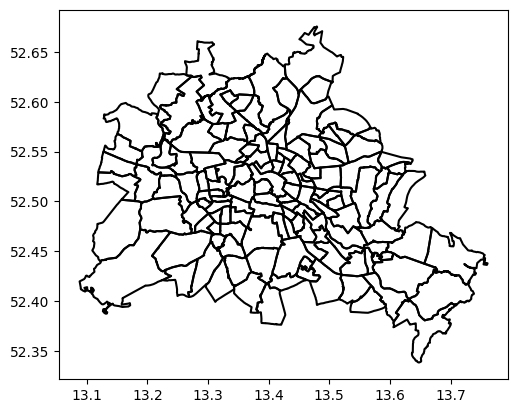

In [345]:
berlin_neighbourhoods = berlin_neighbourhoods_raw[berlin_neighbourhoods_raw["neighbourhood"].notnull()]
berlin_neighbourhoods.boundary.plot(color="black")

The plot above is the map of Berlin, with the neighbourhoods as defined by Airbnb. It is worth to note that these neighbourhood definitions in many parts significantly deviate from the actual official neighbourhoods. However, the 16 `neighbourhood_groups` (not depicted) do refer to the actual districts of the city.

## Language analysis

### Reviews

First I will use [Lingua](https://github.com/pemistahl/lingua-py) to both detect the language for each review comment and also obtain the confidence value of the language detection. Then I will take the language with the highest confidence and append the aforementioned information to the reviews dataframe. While there also might be reviews whose comment features multiple languages, for this project I will only assume the one with the highest confidence for each review.

Iterating over all reviews took multiple hours in my case and on my computer. Therefore, I did this only once and stored the result in `./data/reviews-09-2022-language.csv`. The code which was used to generate this file is commented out in the following cell.

In [18]:
# detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()

# reviews_language = reviews_filtered.copy()
# for i, row in reviews_language.iterrows():
#     if i % 100 == 0:
#       print("Now processing iteration ", i)
#     confidence_values = detector.compute_language_confidence_values(row["comments"])
#     language_lowercase = str(confidence_values[0].language).split(".")[1].lower()
#     reviews_language.at[i,'language_detected'] = language_lowercase
#     reviews_language.at[i,'language_confidence'] = confidence_values[0].value

# reviews_language_url = './data/reviews-09-2022-language.csv'
# reviews_language.to_csv(reviews_language_url, index=False, sep=";", lineterminator="\r")

The custom line terminator `\r` is necessary because some of the comments have linebreaks (`\n`) which break the interpretation of the csv file.

For the following parts I will use the values stored in the aforementioned file.

In [19]:
reviews_language_url = './data/reviews-09-2022-language.csv'
reviews_language_read = pd.read_csv(reviews_language_url, sep=";", lineterminator="\r")

To make sure that only reviews with a somewhat reasonable confidence of the language detection are considered, I chose the minimum of `0.6`. Then I compute the 10 languages that occur the most.

In [20]:
min_required_confidence = 0.6
reviews_confident_language = reviews_language_read[reviews_language_read["language_confidence"] > min_required_confidence]
review_language_occurencies = reviews_confident_language.groupby(by="language_detected").size()
top_10_review_languages = review_language_occurencies.sort_values(ascending=False).head(10)
top_10_review_languages

language_detected
english    251904
german     116793
french      17428
spanish     11216
dutch        4991
italian      4316
russian      2862
chinese      1643
korean       1577
danish       1474
dtype: int64

Unsurprisingly English and German dominate the ranking by far. This is most likely due to both Berlin attracting many international tourists that speak English as the common language with their hosts and also Berlin still being the capital of Germany, also German in the second place is understandable. However, it is still interesting to see in which regards also other languages are present.

In the following cell I plot a bar chart to give a better understanding of the shares of the respective languages.

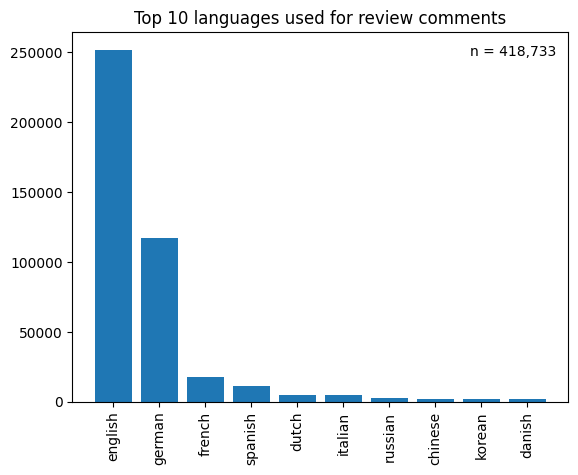

In [21]:
labels = top_10_review_languages.keys()
sizes = top_10_review_languages.values

fig, ax = plt.subplots()
ax.bar(labels, sizes)
plt.xticks(rotation=90)
ax.set_title("Top 10 languages used for review comments")

legend_patch = mpatches.Patch(color='white', label='n = ' + f'{len(reviews_confident_language):,}')
ax.legend(handles=[legend_patch], frameon = False)

plt.show()

Now I would like to find out how the speakers of these languages spread across the city, in terms of how are reviews written in these languages distributed amongst the neighbourhoods of Berlin. Therefore, first I define a function which, for a given language, returns a data frame holding just the distinct neighbourhoods of Berlin together with the share which illustrates how many reviews habe been submitted in that language in the respective neighbourhood of all the reviews submitted in that language in entire Berlin.

In [348]:
def get_neighbourhoods_and_review_shares_for_language(language, reviews=pd.DataFrame([])):
  listings_and_neighbourhoods = berlin_neighbourhoods.merge(listings_with_reviews, on="neighbourhood", how="right")
  listings_and_neighbourhoods = listings_and_neighbourhoods.rename(columns={"id": "listing_id"})

  if reviews.empty:
    reviews = reviews_confident_language

  language_reviews = reviews[reviews["language_detected"] == language]
  language_listings_and_neighbourhoods = language_reviews.merge(listings_and_neighbourhoods, on="listing_id")
  language_review_counts = language_listings_and_neighbourhoods.groupby(by="neighbourhood").size().reset_index(name='counts')
  
  berlin_neighbourhoods_with_counts = berlin_neighbourhoods.merge(language_review_counts, how="left").fillna(0)

  total_occurencies = reviews.groupby(by="language_detected").size()[language]
  berlin_neighbourhoods_with_counts["share"] = berlin_neighbourhoods_with_counts["counts"] / total_occurencies

  return (berlin_neighbourhoods_with_counts, total_occurencies)


Then I define a function which takes a list of languages as parameter and creates one subplot for each of the passed languages which shows the computed share per neighbourhood as a heat map using a continuous color scale. The data is being obtained by calling the previously defined method.

In [349]:
def plot_review_share_per_neighbourhood_for_multiple_language(languages: list[str]):
  rows_count = math.ceil(len(languages) / 2)
  fig, axs = plt.subplots(nrows=rows_count, ncols=2, figsize=(15, 15))

  ravelled_axes = axs.ravel()

  if len(ravelled_axes) > len(languages):
    fig.delaxes(ravelled_axes[-1])

  for (index, language), ax in zip(enumerate(languages), ravelled_axes):
    (language_data, total_occurencies) = get_neighbourhoods_and_review_shares_for_language(language)

    plot = language_data.plot(column = "share", ax = ax, legend=True, legend_kwds={'label': "Share of all reviews in " + language})
    ax.plot = plot
    ax.set_title(language)

    legend_patch = mpatches.Patch(color='white', label='n = ' + f'{total_occurencies:,}')
    ax.legend(handles=[legend_patch], frameon = False)
  
  fig.suptitle("Share of reviews in the respective language per neighbourhood", fontsize=16)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

Now I call the plotting function to show the distribution for 6 of the 10 most used languages.

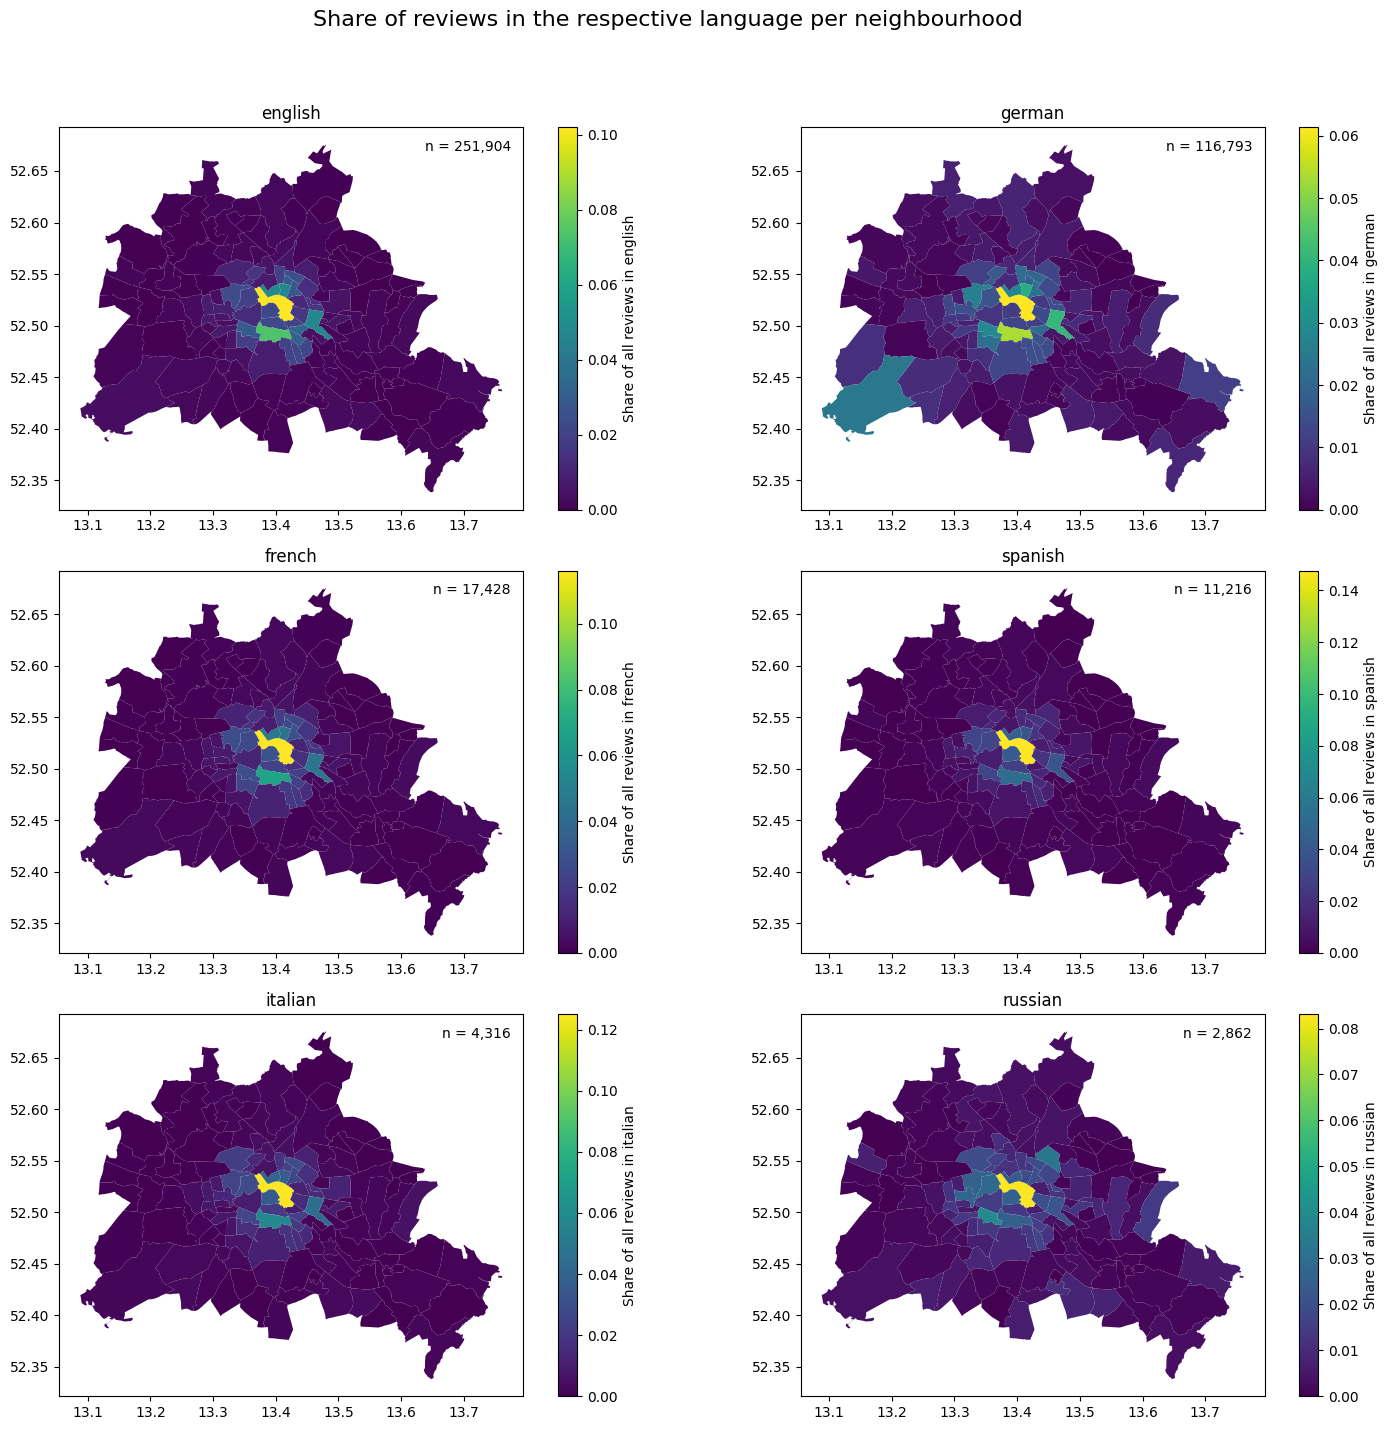

In [25]:
languages = ["english", "german", "french", "spanish", "italian", "russian"]
plot_review_share_per_neighbourhood_for_multiple_language(languages)

One thing that all languages have in common is that the most reviews have been submitted in the most central parts of the city. German is significantly different than the other languages because here districts outside the city center clearly have a higher share than for the other languages, even neighbourhoods at the outskirts have a much brighter colour. Among the foreign languages Russian shows an interesting distribution because here also neighbourhoods at the eastern and western periphery have a distinguishably brighter colour. On the other hand Russian is the language, amongst the ones depicted above, with the lowest set size, so it is also more prone to being distorted by outliers.

In general it can be observed that guests speaking foreign languages are more likely to spend their stay closer to the city center, while German speaking users in comparison spread more throughout the city.

### Listings

Now I would like to do a similar analysis for the listings. While reviews only contain one free text field, the comments, for listings the first important task is to decide which field to include in the analysis. The most relevant free text fields are the `name` and the `description`. To decide which of these to include I will first compute the language for the first 100 listings and inspect the confidence values using the `describe()` method from pandas.

In [27]:
detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()

listings_with_name = listings_with_reviews.head(100)[listings_with_reviews["name"].notna()].copy()
for i, row in listings_with_name.iterrows():
  confidence_values = detector.compute_language_confidence_values(row["name"])

  description_language_lowercase = str(confidence_values[0].language).split(".")[1].lower()
  listings_with_name.at[i,'name_language'] = description_language_lowercase
  listings_with_name.at[i,'name_language_confidence'] = confidence_values[0].value

listings_with_name["name_language_confidence"].describe()

/tmp/ipykernel_95200/368137675.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listings_with_name = listings_with_reviews.head(100)[listings_with_reviews["name"].notna()].copy()


count    100.000000
mean       0.366477
std        0.196001
min        0.068038
25%        0.218787
50%        0.328708
75%        0.482415
max        0.888881
Name: name_language_confidence, dtype: float64

As can be seen the confidence value for the listing name is very low, the maximum not even reaching 1.0 and the 75% percentile being less then 0.5. This is most likely due to the listing name usually being rather short string, mostly consisting only of a few words. As [described in the documentation of the language detector](https://github.com/pemistahl/lingua-py#4-how-good-is-it) it performs significantly better for longer texts.

In [357]:
avg_name_len = listings_with_reviews["name"].str.split(" ").str.len().mean()
avg_description_len = listings_with_reviews["description"].str.split(" ").str.len().mean()
print("Average listing name word length: " + str(round(avg_name_len, 2)))
print("Average listing description word length: " + str(round(avg_description_len, 2)))

Average listing name word length: 5.86
Average listing description word length: 112.56


The description of a listing is on average much longer than its name. Therefore I will use the description to compute the language of a listing. First I will drop entries which do not contain a name or a review.

In [28]:
listings_with_name_and_description = listings_with_reviews[listings_with_reviews["name"].notna() & listings_with_reviews["description"].notna()]
listings_with_name_and_description.reset_index(inplace=True)

Next I will use an approach similar to the one for computing the review languages, iterating over all the listings and computing both the description language and the confidence and appending these information to the data frame. Also in this case to save time, I did this once and stored the result in `./data/listings-09-2022-language.csv`. The code which generated that file is commented out in the following cell.

In [29]:
# listings_languages = listings_with_name_and_description.copy()

# for i, row in listings_languages.iterrows():
#   if i % 100 == 0:
#     print("Now processing iteration ", i)
#   confidence_values_description = detector.compute_language_confidence_values(row["description"])

#   description_language_lowercase = str(confidence_values_description[0].language).split(".")[1].lower()
#   listings_languages.at[i,'description_language'] = description_language_lowercase
#   listings_languages.at[i,'description_language_confidence'] = confidence_values_description[0].value

# listings_language_url = './data/listings-09-2022-language.csv'

# listings_languages.drop(columns=["index"]).to_csv(listings_language_url, index=False, sep=";", lineterminator="\r")

In [30]:
listings_language_url = './data/listings-09-2022-language.csv'
listings_language_read = pd.read_csv(listings_language_url, sep=";", lineterminator="\r")

Now for a quick comparison, the confidence values for the description language.

In [31]:
listings_language_read["description_language_confidence"].describe()

count    13612.000000
mean         0.988646
std          0.082567
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: description_language_confidence, dtype: float64

The difference to the values for the listing name is huge. The mean is at ~0.99 and even the 25% percentile is 1.0.
However apparently there are still values with a very low confidence, with the minimum being 0. To do proper assumptions I will again only consider entries with a minimum confidence of 0.6.

In [32]:
min_required_confidence = 0.6
listings_desc_confident_language = listings_language_read[listings_language_read["description_language_confidence"] > min_required_confidence]
listing_desc_language_occurencies = listings_desc_confident_language.groupby(by="description_language").size()
top_10_listing_languages = listing_desc_language_occurencies.sort_values(ascending=False).head(10)
top_10_listing_languages

description_language
english       8637
german        4676
russian         52
spanish         22
french          21
italian         12
dutch            5
polish           5
turkish          4
portuguese       4
dtype: int64

Similar to the reviews the top two languages are English and German. What is different is that the other languages have a much smaller share. Again I will plot a bar chart to get a better visualization of these shares.

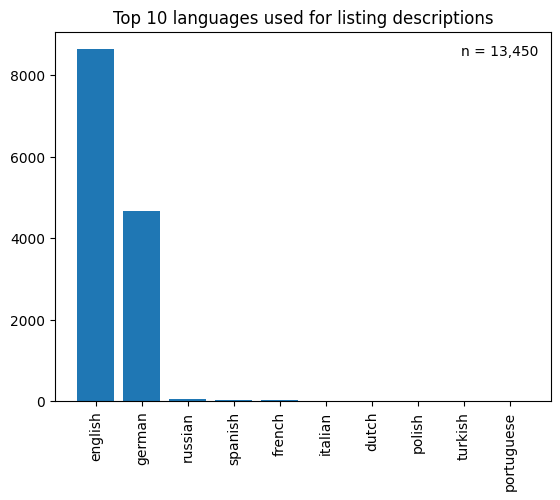

In [33]:
labels = top_10_listing_languages.keys()
sizes = top_10_listing_languages.values

fig, ax = plt.subplots()
ax.bar(labels, sizes)
plt.xticks(rotation=90)
ax.set_title("Top 10 languages used for listing descriptions")

legend_patch = mpatches.Patch(color='white', label='n = ' + f'{len(listings_desc_confident_language):,}')
ax.legend(handles=[legend_patch], frameon = False)

plt.show()

As seen in the numbers, the bars for the languages other than English and German are close to non-existent.

For understanding how the languages used for the listing descriptions distribute across the city I will again define a method which, for a given language, returns the distinct neighbourhoods and for each of these the amount of how many listings used this language. What is different is that instead of returning the share of each neighbourhood compared to the total number of listings in that language I will return the absolute numbers, because later on there will be a use case where these numbers will be useful.

In [358]:
def get_neighbourhoods_and_description_counts_for_language(language):
  language_listings = listings_desc_confident_language[listings_desc_confident_language["description_language"] == language]
  language_counts = language_listings.groupby(by="neighbourhood").size().reset_index(name='counts')
  
  return berlin_neighbourhoods.merge(language_counts, how="left").fillna(0)

Also the method creating the heatmap subplots for multiple given languages is similar to the one being used for the reviews.

In [34]:
def plot_description_shares_per_neighbourhood_for_multiple_languages(languages: list[str]):
  rows_count = math.ceil(len(languages) / 2)
  fig, axs = plt.subplots(nrows=rows_count, ncols=2, figsize=(15, 15))

  ravelled_axes = axs.ravel()

  if len(ravelled_axes) > len(languages):
    fig.delaxes(ravelled_axes[-1])

  for (index, language), ax in zip(enumerate(languages), ravelled_axes):
    language_data = get_neighbourhoods_and_description_counts_for_language(language)
    total_occurencies = listing_desc_language_occurencies[language]
    language_data["share"] = language_data["counts"] / total_occurencies
    
    ax.plot = language_data.plot(column = "share", ax = ax, legend=True, legend_kwds={'label': "Share of all descriptions in " + language})
    ax.set_title(language)

    legend_patch = mpatches.Patch(color='white', label='n = ' + f'{total_occurencies:,}')
    ax.legend(handles=[legend_patch], frameon = False)
  
  fig.suptitle("Share of descriptions in the respective language per neighbourhood", fontsize=22)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

Now I will plot the four most common listing languages and their distribution across the city.

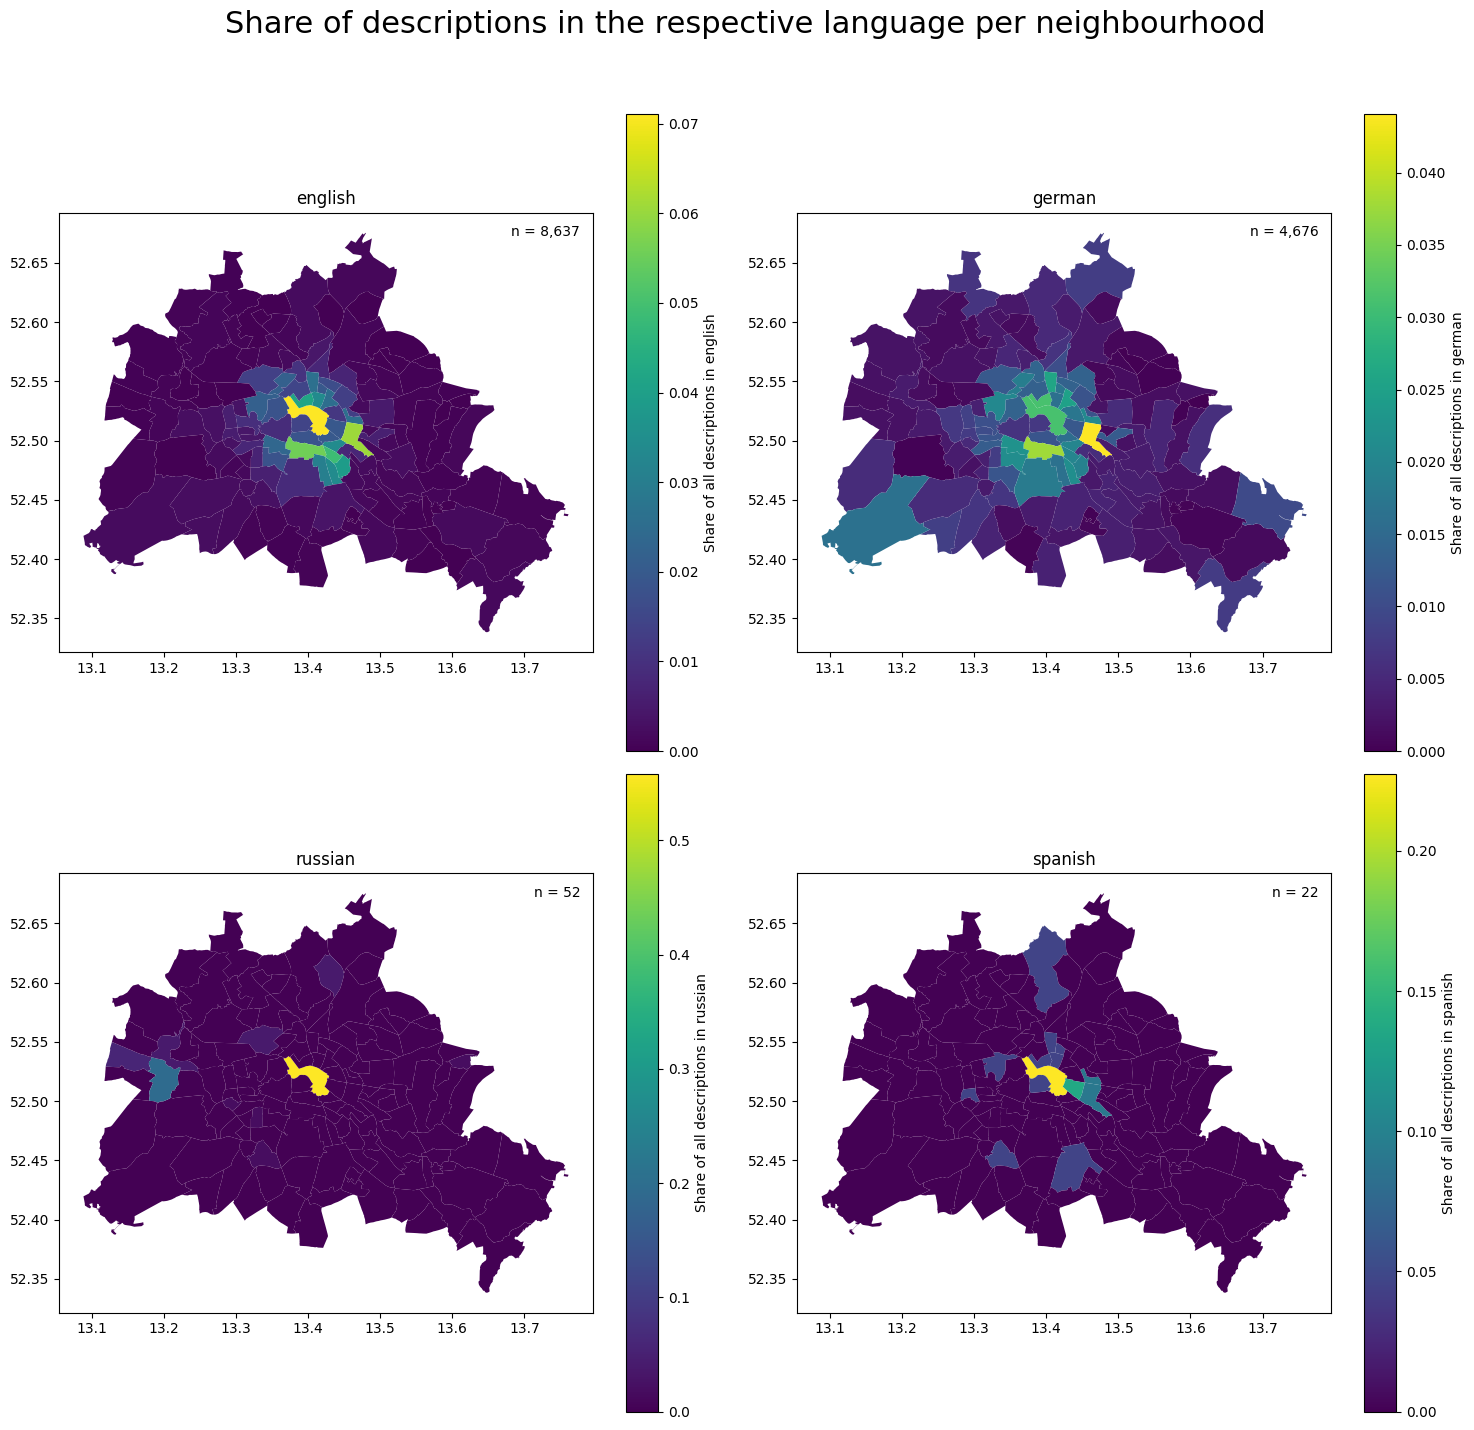

In [35]:
plot_description_shares_per_neighbourhood_for_multiple_languages(["english", "german", "russian", "spanish" ])

Similar to the behaviour of reviewers using German and English for different parts of the city, it can also be observed for listings that English entries rather circle around the city center, while hosts use German to describe their accomodation more throughout the entire city. What really raised my attention is the distribution of Russian descriptions. While the size of the data set is very low with just 52 entries (compared to more than 8,000 and 4,000 for English and German respectively) it seems to concentrate not just in the city center but also in a neighbourhood at the western outskirts.

Using the aforementioned method, which provided the data for the heatmap subplots, I will further investigate this distribution.

In [368]:
neighbourhoods_russian = get_neighbourhoods_and_description_counts_for_language("russian")
merged_neighbourhoods = berlin_neighbourhoods.merge(neighbourhoods_russian, how="left")
merged_neighbourhoods.sort_values(by="counts", ascending=False).head(5)[["neighbourhood", "neighbourhood_group", "counts"]]

,neighbourhood,neighbourhood_group,counts
15,Alexanderplatz,Mitte,29.0
50,Wilhelmstadt,Spandau,10.0
45,Brunsbütteler Damm,Spandau,3.0
19,Parkviertel,Mitte,2.0
113,Spandau Mitte,Spandau,2.0


"Alexanderplatz" is the yellow neighbourhood in the city center which shows the highest density for all the languages. It is interesting that the following two neighbourhoods are both in the district "Spandau" which resides at the western city boundary and is not even close to the city center.

In [371]:
russian_listings = listings_desc_confident_language[listings_desc_confident_language["description_language"] == "russian"]
russian_listings_in_wilhelmstadt = russian_listings[russian_listings["neighbourhood"] == "Wilhelmstadt"]
russian_listings_in_wilhelmstadt.sort_values("host_id")[["host_id", "price", "accommodates", "name", "description"]]

,host_id,price,accommodates,name,description
2818,52747435,60.0,4,Двухкомнатная квартира на Штаакенер (19),Если вы хотите пожить в знаменитом районе г.Б...
6147,52747435,56.0,4,Двухкомнатная квартира на Штаакенер (32),Если вы хотите пожить в знаменитом районе г.Бе...
6359,52747435,60.0,5,Cosy 2rooms Apartment in Spandau area (2),"Уютная двухкомнатная квартира, оснащенная всем..."
6838,52747435,60.0,4,Двухкомнатная квартира на Штаакенер (5),Если вы хотите пожить в знаменитом районе г. Б...
7199,52747435,57.0,4,Двухкомнатная квартира на Штаакенер (24.2),Если вы хотите пожить в знаменитом районе г.Бе...
4623,79430806,55.0,5,Stylish 2-rooms flat on Staakenerstr. Spandau(21),Современная просторная двухкомнатная квартира ...
5860,79430806,55.0,5,Comfy 2rooms flat in Spandau (29),Современная просторная двухкомнатная квартира ...
6474,79430806,51.0,4,2Rooms flat in quiet neighborhood/Spandau (22),Уютная небольшая двухкомнатная квартира 44 м2 ...
7162,79430806,53.0,4,Small 2Rooms flat (24.1)/Spandau,Маленькая 2-х комнатная квартира площадью 37 м...
7419,79430806,55.0,5,Nice 2Rooms flat/Spandau (17),Современная просторная двухкомнатная квартира ...


Apparently in the neighbourhood "Wilhelmstadt", which takes place 2 in the ranking of neighbourhoods where the Russian language is used for descriptions, there are two hosts, each of whom offering five accomodations and all of them having a similar price and number of guests that can be accommodated.

Taking a step back from this little detailled field trip into the data, for the listings the same trend can be observed as for the reviews: The dominating languages are English and German and while English descriptions are mostly found in the city center, German descriptions are used also in many peripheral neighbourhoods. What is different is that other languages do not play a significant role.

## Sentiment analysis

For the sentiment analysis part I will only refer to English reviews to avoid any distortions between the computed sentiments which might arise from language models having different performance quality.

In [38]:
english_reviews = reviews_confident_language[reviews_confident_language["language_detected"] == "english"]

For classifying sentiments I will use [flairNLP](https://github.com/flairNLP/flair).

In [40]:
classifier = TextClassifier.load('en-sentiment')

2023-01-11 21:19:41,572 loading file /home/lebkuchen/.flair/models/sentiment-en-mix-distillbert_4.pt


Now I will define the functions being used for the sentiment computation. Since flairNLP works based on sentences first I have to break down the content of a comment into sentences.

In [372]:
def get_sentences_from_text(text: str):
    sentences = [sent for sent in split_single(text)]
    return sentences

After that I create a function which generates a sentiment for a given sentence. The classifier either predicts `POSITIVE` or `NEGATIVE`, additional to the confidence value. The latter one will be used as score: The higher the confidence, the more positive or negative is the sentence. The confidence receives the negative algebraic sign in case the sentiment is negative.

In [373]:
def predict(sentence: str):
    if sentence == "":
        return 0
    text = Sentence(sentence)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = text.to_dict()['all labels'][0]['confidence']
    else:
        result = -(text.to_dict()['all labels'][0]['confidence'])
    return round(result, 3)

Now I define a function which takes a list of sentences and iterates over them, calling the previously defined `predict()` method and returning a list with the results.

In [375]:
def get_scores(sentences):
    results = []
    
    for i in range(0, len(sentences)): 
        results.append(predict(sentences[i]))
    return results

Finally this small method will compute the overall sentiment of a review text by computing the sum of the scores for each sentence. I was thinking of computing the overall sentiment as a value between -1 and 1, by computing a weighted average. But in the end I decided to do it this way because reviews can have different lengths and in my opinion an entirely positive review that has 10 sentences should have more value than an entirely positive review which only consists of 2 sentences.

In [41]:
def get_sum(scores):
    result = round(sum(scores), 3)
    return result

Computing the sentiments of all the reviews takes very long on my machine. This is why will only use a subset of the data for the following steps by taking a sample of 50,000 reviews.

In [42]:
english_reviews_sample = english_reviews.sample(n = 50000)

Still with 50,000 reviews it took more than 5 hours to compute all the sentimens. Therefore, I again stored the results in a file so that they have to be calculated only once. In the following cell is the commented out code which generated this file.

Before calling the previously defined methods I did additional preprocessing in the sense that I first convert the review text into lower case form and then removing HTML linebreaks (`<br/>`) which are present in many reviews but do not add any relevant information.

In [43]:
# reviews_with_sentiment = english_reviews_sample.copy()
# reviews_with_sentiment.reset_index(inplace=True)

# for index, review in reviews_with_sentiment.iterrows():
#   review_comment = review["comments"]
#   comment_lowercase = review_comment.lower()
#   comment_without_html_linebreaks = comment_lowercase.replace("<br/>", "")

#   sentences = get_sentences_from_text(comment_without_html_linebreaks)
#   scores = get_scores(sentences)
#   sentiment_sum = get_sum(scores)
  
#   reviews_with_sentiment.at[index, 'sentiment'] = sentiment_sum

# reviews_sentiment_url = './data/reviews-09-2022-sentiment.csv'
# reviews_with_sentiment.drop(columns=["index"]).to_csv(reviews_sentiment_url, index=False, sep=";", lineterminator="\r")

In [44]:
reviews_sentiment_url = './data/reviews-09-2022-sentiment.csv'
reviews_sentiment_read = pd.read_csv(reviews_sentiment_url, sep=";", lineterminator="\r")

First I would like to do a plausability check to see if the sampled subset of 50,000 reviews is at least somewhat representative to the entire collection of English reviews. Therefore, I will create a heatmap showing the distribution of the sentiment-analysed reviews throughout the city and compare it with the distribution of all English reviews.

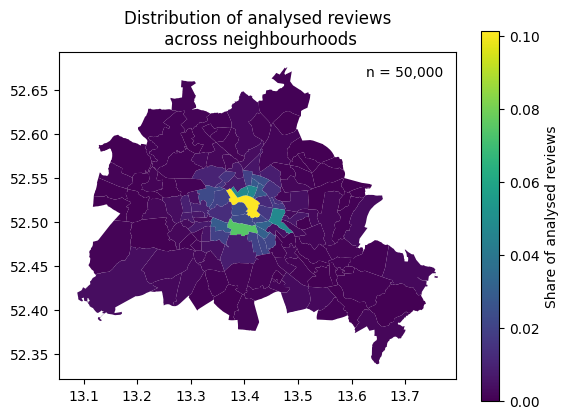

In [47]:
(review_sentiment_shares, analysed_occurencies) = get_neighbourhoods_and_review_shares_for_language(language="english", reviews=reviews_sentiment_read)
fig, ax = plt.subplots()
ax.plot = (review_sentiment_shares).plot(column = "share", ax = ax, legend=True, legend_kwds={'label': "Share of analysed reviews"})

legend_patch = mpatches.Patch(color='white', label='n = ' + f'{analysed_occurencies:,}')
ax.legend(handles=[legend_patch], frameon = False)
ax.set_title("Distribution of analysed reviews\n across neighbourhoods")

plt.show()


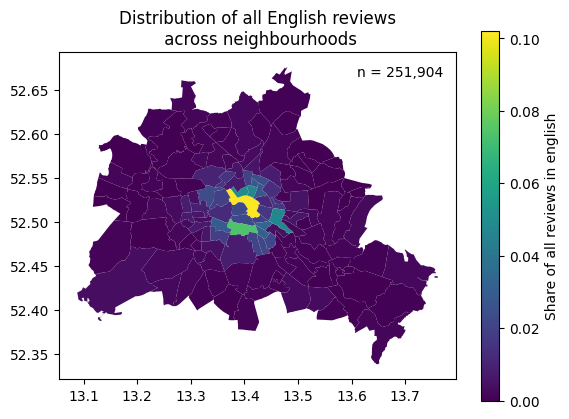

In [48]:
language = "english"
(reviews_english_total_shares, total_occurencies) = get_neighbourhoods_and_review_shares_for_language(language)

fig, ax = plt.subplots()
plot = reviews_english_total_shares.plot(column = "share", ax = ax, legend=True, legend_kwds={'label': "Share of all reviews in " + language})
ax.plot = plot

legend_patch = mpatches.Patch(color='white', label='n = ' + f'{total_occurencies:,}')
ax.legend(handles=[legend_patch], frameon = False)
ax.set_title("Distribution of all English reviews\n across neighbourhoods")

plt.show()

Looking at these two maps I see that the two data sets have a very similar distribution. This provides confidence that in the sampled dataset are at least no extreme outliers in the regards of distribution that would distort the further analysis.

Having the sentiment scores of the reviews stored as a numerical value I will classify them additionally with a text label, depending on whether the score is greater than 0 or not.

In [45]:
for index, review in reviews_sentiment_read.iterrows():
  sentiment_category = "positive" if review["sentiment"] > 0 else "negative"
  reviews_sentiment_read.at[index, 'sentiment_category'] = sentiment_category

positive_negative_occurencies = reviews_sentiment_read.groupby(by="sentiment_category").size()

Now I will show the distribution of all the analysed reviews into these two categories with a pie chart.

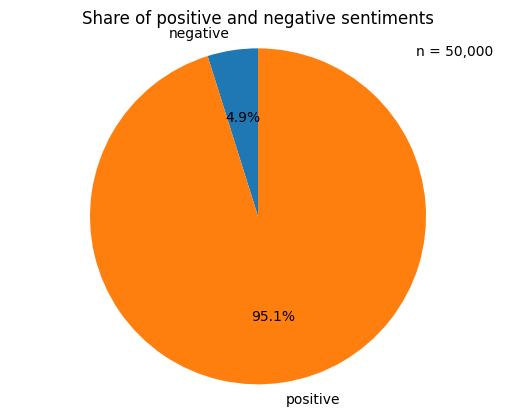

In [376]:
labels = positive_negative_occurencies.keys()
sizes = positive_negative_occurencies.values

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax.axis('equal')
ax.set_title("Share of positive and negative sentiments")

legend_patch = mpatches.Patch(color='white', label='n = ' + f'{analysed_occurencies:,}')
ax.legend(handles=[legend_patch], frameon = False)

plt.show()

Apparently more than 95% of the analysed reviews have a positive sentiment. If this applies similarly to the entire data set it can be estimated that most of the reviews submitted for Airbnb accommodations in Berlin have a positive sentiment.

To further investigate the distribution of the sentiment scores in the two categories I will use box plots. For better comparability I will normalise the negative sentiments so that the y-axis can be shared properly.

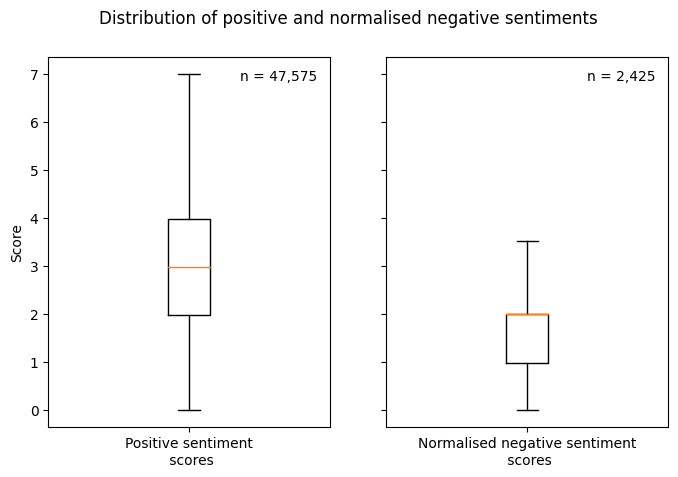

In [383]:
positive_reviews = reviews_sentiment_read[reviews_sentiment_read["sentiment_category"] == "positive"]["sentiment"]
negative_reviews = reviews_sentiment_read[reviews_sentiment_read["sentiment_category"] == "negative"]["sentiment"]
negative_reviews_normalised = negative_reviews * -1

positive_legend_patch = mpatches.Patch(color='white', label='n = ' + f'{len(positive_reviews):,}')
negative_legend_patch = mpatches.Patch(color="white", label='n = ' + f'{len(negative_reviews_normalised):,}')

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)

axs[0].boxplot(positive_reviews, labels=["Positive sentiment\n scores"], showfliers=False)
axs[0].legend(handles=[positive_legend_patch], frameon = False, loc="upper right")
axs[0].set_ylabel('Score') 
axs[1].boxplot(negative_reviews_normalised, labels=["Normalised negative sentiment\n scores"], showfliers=False)
axs[1].legend(handles=[negative_legend_patch], frameon = False)

fig.suptitle("Distribution of positive and normalised negative sentiments")
fig.set_figwidth(8)

plt.show()

What becomes obvious is that above the minimum the percentiles for positive sentiments are significantly higher than the normalised negative scores. So not only are there by far more positive sentiments than negative, the average positive review seems to be more positive than the average negative review is negative.

Now I would like to find out how the sentiments distribute across the city. Therefore, similarly to the steps before, I will make use of heat maps showing the average sentiment per neighbourhood. First I define a function that provides the necessary joined data. What is different from the previous functions is that in this case I will add a `threshold` as parameter. I will show soon why this is necessary.

In [385]:
def get_neighbourhoods_and_average_sentiment_score(threshold: int = None):
  listings_and_neighbourhoods = berlin_neighbourhoods.merge(listings_with_reviews, on="neighbourhood", how="right")
  listings_and_neighbourhoods = listings_and_neighbourhoods.rename(columns={"id": "listing_id"})

  listings_and_neighbourhoods_and_sentiment = reviews_sentiment_read.merge(listings_and_neighbourhoods, on="listing_id")
  n = len(listings_and_neighbourhoods_and_sentiment)
  avg_sentiment_per_neighbourhood = listings_and_neighbourhoods_and_sentiment.groupby(by="neighbourhood")['sentiment'].mean()
  if threshold != None:
    neighbourhoods_and_counts = listings_and_neighbourhoods_and_sentiment.groupby(by="neighbourhood").size()

    mask = neighbourhoods_and_counts >= threshold
    neighbourhoods_to_keep = neighbourhoods_and_counts[mask].keys()
    neighbourhoods_to_keep_pattern = '|'.join(neighbourhoods_to_keep)
    
    n = neighbourhoods_and_counts[mask].sum()
    avg_sentiment_per_neighbourhood = avg_sentiment_per_neighbourhood.filter(regex=neighbourhoods_to_keep_pattern)
  
  return (berlin_neighbourhoods.merge(avg_sentiment_per_neighbourhood, how="left", on="neighbourhood"), n)

After having this method defined I will call it to obtain the data necessary for the plotting. Additionally to the colours from the continuous colour scale I need to add a value for non-existing data, because due to the dataset being much smaller than the original there are a few neighbourhoods without data. For previous heat maps it was a valid option to treat them as 0, because they were always about how often something is present in the respective neighbourhood. In this case though I am computing an average value so treating these neighbourhoods like 0-values would be misleading.

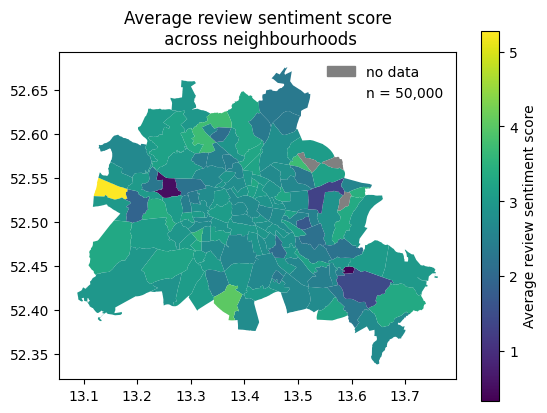

In [394]:
(avg_review_sentiment_data, n) = get_neighbourhoods_and_average_sentiment_score()

fig, ax = plt.subplots()
missing_kwds = dict(color='grey')

ax.plot = avg_review_sentiment_data.plot(column = "sentiment", missing_kwds=missing_kwds, ax = ax, legend=True, legend_kwds={'label': "Average review sentiment score"})

legend_patch = mpatches.Patch(color='white', label='n = ' + f'{n:,}')
no_data_patch = mpatches.Patch(color='grey', label='no data')
ax.legend(handles=[no_data_patch, legend_patch], frameon = False)
ax.set_title("Average review sentiment score\n across neighbourhoods")

plt.show()

The first things that come to my attention are very bright colours at the city boundaries. This is mainly to the dataset being much smaller than the original one and therefore more prone to outliers distorting the overall value of an area. 

Therefore I will make use of the previously introduced `threshold` parameter to only obtain neighbourhoods that have at least a certain number of reviews.

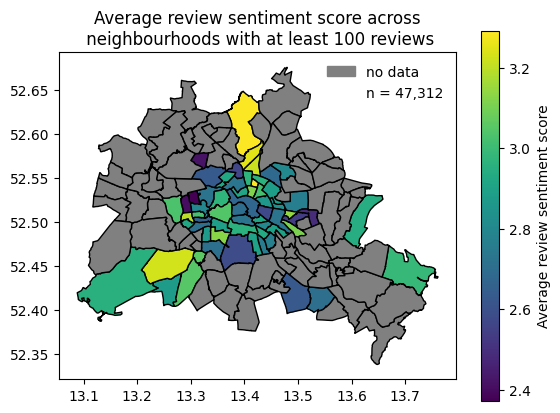

In [396]:
threshold = 100
(avg_review_sentiment_data, n) = get_neighbourhoods_and_average_sentiment_score(threshold=threshold)

fig, ax = plt.subplots()

missing_kwds_color = 'grey'
missing_kwds = dict(color=missing_kwds_color)
ax.plot = avg_review_sentiment_data.plot(column = "sentiment", missing_kwds=missing_kwds, edgecolor="black",
 ax = ax, legend=True, legend_kwds={'label': "Average review sentiment score"})

legend_patch = mpatches.Patch(color='white', label='n = ' + f'{n:,}')
no_data_patch = mpatches.Patch(color=missing_kwds_color, label='no data')
ax.legend(handles=[no_data_patch, legend_patch], frameon = False)

ax.set_title("Average review sentiment score across\n neighbourhoods with at least %s reviews" % threshold)

plt.show()

While a lot of neighbourhods are now grey because they do not have enough data, there are still more than 47,000 out of 50,000 reviews included. Also the distribution of the colour scale changed: Spanning from less than 1 to more than 5 with all 50,000 reviews now the lowest depicted value on the scale is 2.4 whereas the highest is 3.2.

When looking at the map one can see a concentration of neighbourhoods with a rather high average score in the north east of the city. (This concentration is also the reason why I added black outlines, otherwise it would have been rather hard to distinguish the borders between those areas with a high score) 

I will print the top 5 neighbourhoods from the dataframe that was used for the now discussed map.

In [397]:
top_5_neighbourhoods_sentiment = avg_review_sentiment_data.sort_values(by="sentiment", ascending=False).head(5)
top_5_neighbourhoods_sentiment[["neighbourhood", "neighbourhood_group", "sentiment"]]

,neighbourhood,neighbourhood_group,sentiment
1,Helmholtzplatz,Pankow,3.291558
0,Blankenfelde/Niederschönhausen,Pankow,3.285144
27,Pankow Zentrum,Pankow,3.251862
57,Zehlendorf Nord,Steglitz - Zehlendorf,3.228203
31,Pankow Süd,Pankow,3.219557


As can be observed 4 out of the top 5 neighbourhoods with the highest average sentiment score belong to the district of Pankow, which is in the north east. 

Analysing the sentiment scores for review comments showed that on one hand there are by far more reviews with a positive than with a negative sentiment but also the scores of positive sentiments are significantly higher than the normalised scores of negative comments. Also it could be shown in which parts of the city people submit on average more positive reviews after their stay. 

However these insights are subject to perhaps only showing one part of the truth, as the investigated dataset was only a subsample of the entire dataset of English reviews. Also the way the sentiment is calculated for each review plays an important role; if the value would represent an average instead of a sum it might drastically change the situation since then long reviews containing only one sentiment would play a less important role than with the chosen approach.

Also there was little preprocessing happening on the texts itselves. Only one kind of stop word was removed at the beginning of the process, probably the result would also look different if further cleaning would have taken place.

## Review clustering

The goal is to find a way to use clustering to discover possible similarities among the reviews. For the clustering I will use an approach with multiple stages. 

First the reviews need to be cleaned and preprocessed in order to remove data that does not provide much information.

Then I will use Doc2Vec to create a numerical representation of each review comment. This will then be the basis for a K-means clustering.

Finally I will try multiple combinations of parameters for Doc2Vec and K-means to tune the underlying models and maximize scoring values.

For the preprocessing stage I will mainly rely on tools provided by `NLTK`. At the beginning the review comment is being tokenized, so split up into an array of substrings. Then non-alphabetic strings are being removed and tokens are stored in lower case to have a uniform representation. Stop word removal increases the amount of information of each comment by sorting out words that are common in the English language. In the end the lemmatizer converts every term into its dictionary form so that words with the same stem but different declination will be recognized as the same information.

In [266]:
def preprocess(text):
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

I will use Doc2Vec as representational model. It is an unsupervised algorithm based on Word2Vec, however other than Word2Vec it does not represent single words as vectors but entire documents with any number of words.

For the actual clustering I will use k-Means, which is also an unsupervised algorithm. As tuning parameters I picked the number of clusters for k-Means, the vector size for Doc2vec as well as the algorithm used to train the model, either "Distributed Memory" (DM, equals value 1) or "Distributed Bag of Words" (DBOW, equals value 0). While the first one recognizes the order of the terms in a document, the latter only considers the appearance and the frequency of terms.

In [402]:
def doc2vec_kmeans(comments, n_clusters = 5, vector_size = 100, doc2vec_algo=1):
  tagged_comments = [TaggedDocument(comment.split(), [i]) for i, comment in enumerate(comments)]

  model = Doc2Vec(tagged_comments, vector_size=vector_size, window=10, min_count=1, workers=4, dm=doc2vec_algo)

  comment_vectors = [model.infer_vector(comment.split()) for comment in comments]

  kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(comment_vectors)

  return (comment_vectors, kmeans)

The following method creates a plot consisting of two subplots, which depict the calculated score values depending on the number of clusters.

In [418]:
def print_silhouette_and_calihara_plots(n_clusters: range, silhouette_list: list, calihara_list: list, title = ''):
    fig, ax = plt.subplots(2, sharex=True)
    if title != '':
        fig.suptitle(title)
        
    silhouette_color = 'orange'
    ax[0].plot(n_clusters, silhouette_list, color=silhouette_color)
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('Silhouette score') 
    ax[0].set_xticks(range(min(n_clusters), max(n_clusters)+1, 1))
    silhouette_highscore = round(max(silhouette_list), 2)
    silhouette_highscore_patch = mpatches.Patch(color=silhouette_color, label='Best score: ' + str(silhouette_highscore))
    ax[0].legend(handles=[silhouette_highscore_patch], frameon = False)

    calihara_color = 'blue'
    ax[1].plot(n_clusters, calihara_list, color=calihara_color)
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Calinski-Harabasz score')
    ax[1].yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
    calihara_highscore = round(max(calihara_list), 2)
    calihara_highscore_patch = mpatches.Patch(color=calihara_color, label='Best score: ' + f'{total_occurencies:,}')
    ax[1].legend(handles=[calihara_highscore_patch], frameon = False)

This method mainly iterates through the desired ranges for the cluster and vector size variables. For each combination it creates the document vectors and clusters and calculates two scores with these which are then passed to the plotting method.

One commonly used metric is the silhouette score, which measures how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, with a value of 1 indicating that the object is very well matched to its own cluster and a value of -1 indicating that the object is probably assigned to the wrong cluster.

Another metric commonly used is the Calinski-Harabasz index, which is calculated as the ratio of the between-clusters variance to the within-cluster variance. A higher Calinski-Harabasz index indicates a better clustering solution.

In [413]:
def cluster_and_plot_scores(comments, doc2vec_algo=1):
    vector_size_range = range(50, 151, 50)
    n_clusters_range = range(2, 11)

    for vector_size in vector_size_range:
        silhouette_list = []
        calihara_list = []

        for n_clusters in n_clusters_range:
            (vectors, kmeans) = doc2vec_kmeans(comments, n_clusters=n_clusters, vector_size=vector_size, doc2vec_algo=doc2vec_algo)
            silhouette = silhouette_score(vectors, kmeans.labels_)
            calihara = calinski_harabasz_score(vectors, kmeans.labels_)
            
            silhouette_list.append(silhouette)
            calihara_list.append(calihara)

        algo = "DBOW" if doc2vec_algo == 0 else "DM"
        title = 'Doc2vec vector size: ' + str(vector_size) + ', Doc2vec algorithm: ' + algo
        print_silhouette_and_calihara_plots(n_clusters_range, silhouette_list, calihara_list, title)

For this task I will again use only a sample of the sentiment data, since with these many different combinations of parameters it already takes 15-20 minutes on my computer to create the clusters and evaluate them.

This subset first needs to be preprocessed, as described before.

In [ ]:
comments = reviews_sentiment_read.head(5000)["comments"]
comments_preprocessed = [preprocess(comment) for comment in comments]

Then I will plot the results of the iterations, using the `DM` algorithm for training the Doc2Vec model.

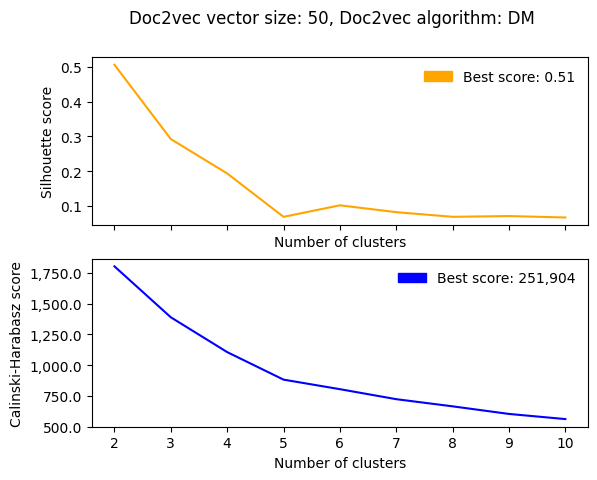

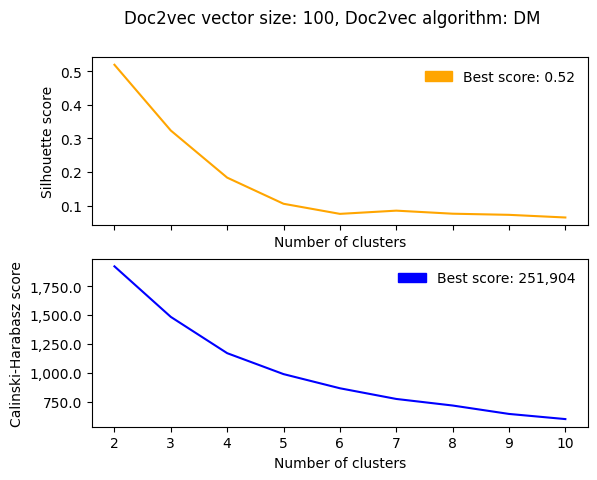

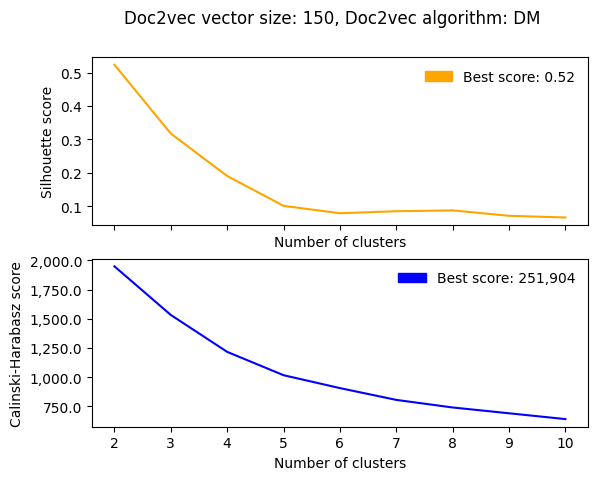

In [419]:
cluster_and_plot_scores(comments_preprocessed, doc2vec_algo=1)

There is a high correlation between the two considered scores. The more clusters there are, the lower the score values become. Apparently by far the best result can be achieved by using not more than 2 clusters. But this applies to the `DM` Doc2vec algorithm. Now I need to also do the same calculation using `DBOW`.

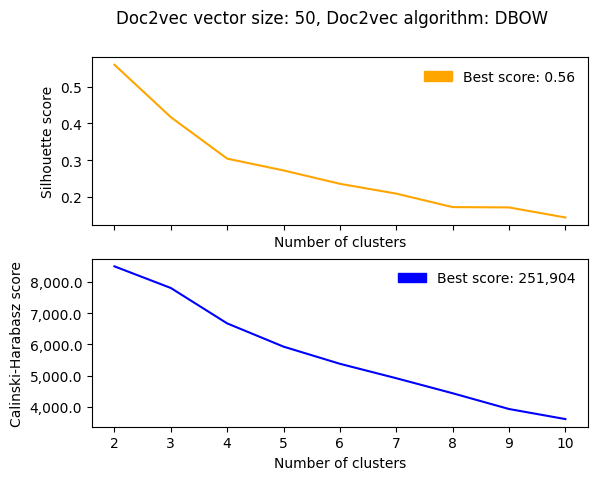

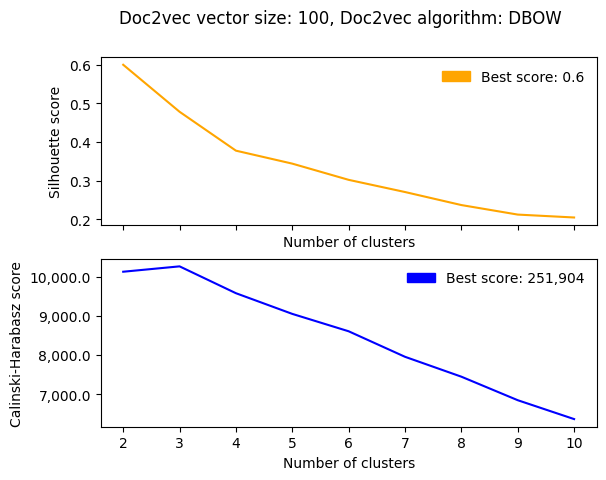

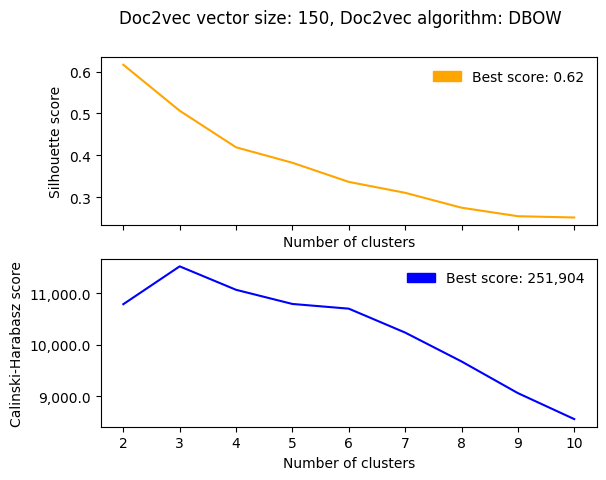

In [420]:
cluster_and_plot_scores(comments_preprocessed, doc2vec_algo=0)

While the Silhouette score curves look very similar to those depicted for the `DM` algorithm, the Calinski-Harabasz score looks different: For the vector sizes 100 and 150 the best score is achieved for 3 clusters instead of 2. In general the values of the scores are higher, the best Silhouette could increase from 0.52 to 0.62 for the 150 vector size, the peak for Calinski-Harabasz grew nearly by the factor of 6, from 1,954 to 11,429. So by choosing a different algorithm for the vector representation the clustering performs also much better.

Now it would be interesting to know what the optimal clusters look like. To inspect them I would like to know which are the most common words per cluster. Therefore I define the following method which takes the comments and the assigned cluster labels to compute a frequency distribution.

In [421]:
def print_most_common_words(comments: list[str], cluster_label):
    clusters_words = defaultdict(list)

    for comment, label in zip(comments, cluster_label):
        clusters_words[label].append(comment)

    clusters_ordered = dict(sorted(clusters_words.items()))
    for label, comments_cluster in clusters_ordered.items():
        words_distribution = FreqDist([word for comment in comments_cluster for word in comment.split()])
        most_common_words = words_distribution.most_common(10)
        print(f"{label}: {most_common_words}")

Taking one of the best-scoring parameter combinations from the previous loop I will now first compute the word vectors and the clusters before passing the latter to the function defined one cell above, together with the preprocessed comments.

In [422]:
(vectors, kmeans) = doc2vec_kmeans(comments_preprocessed, n_clusters=3, vector_size=150, doc2vec_algo=0)
print_most_common_words(comments_preprocessed, kmeans.labels_)

0: [('great', 343), ('location', 241), ('host', 210), ('place', 199), ('apartment', 191), ('nice', 167), ('stay', 159), ('clean', 140), ('good', 114), ('recommend', 103)]
1: [('great', 759), ('place', 550), ('apartment', 536), ('location', 522), ('stay', 446), ('nice', 440), ('clean', 407), ('host', 389), ('good', 298), ('recommend', 295)]
2: [('apartment', 2106), ('great', 1704), ('place', 1626), ('stay', 1504), ('berlin', 1349), ('nice', 1046), ('clean', 1031), ('u', 995), ('location', 979), ('host', 941)]


There are a lot of terms that appear in more than one, some of them even in all three clusters with a high frequency, such as "great" or "place". On the other hand some terms seem to be exclusive, such as "u" (the lemmatized version of "us") in cluster 2 or "berlin", also in cluster 2. For better distinguishability it might be beneficial to put the former mentioned terms also on the list of stop words to filter them out during the preprocessing step.

Now how do the documents and the clusters look like? To get a 2-dimensional representation of the dataset I perform a  principal component analysis with 2 components on the document vectors and use the cluster labels to colour the points. 

In [423]:
def scatter_clustered_plot_reviews(vectors, cluster_labels):
  pca = PCA(n_components=2)
  pca.fit(vectors)
  review_vectors_2d = pca.transform(vectors)

  scatter = plt.scatter(review_vectors_2d[:, 0], review_vectors_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.4)
  plt.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")

  plt.xlabel('PCA Component 1')
  plt.ylabel('PCA Component 2')
  plt.title('Scatter plot of reviews')

  plt.show()

The result looks like this:

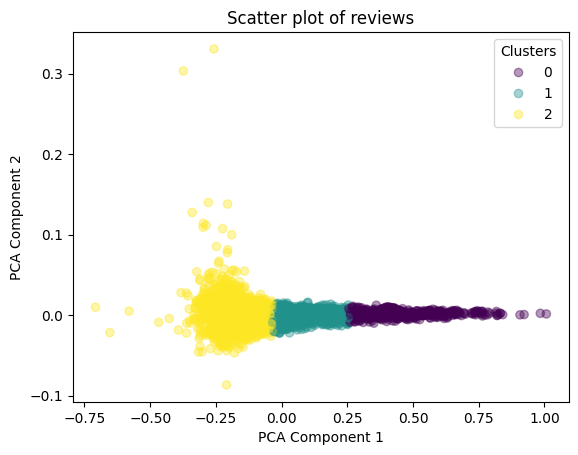

In [424]:
scatter_clustered_plot_reviews(vectors, kmeans.labels_)

It becomes more apparent now why cluster 2 has rather exclusive terms, as discovered before: It contains much more outliers than the other two clusters. But apart from them another finding is that the clusters are very close to each other and have a lot of overlaps. Probably this would also be different if the most frequent terms, that all clusters have in common, would be removed from the corpus.

In general there are so many more options how this approach might be improved. The chosen 